# Explaining Speech Classification Models with Feature Attribution

---

Author: Gaofei Shen

---

This notebook is part of the [Interspeech 2025](https://www.interspeech2025.org/home) tutorial on [_Interpretability Techniques for Speech Models_](https://interpretingdl.github.io/speech-interpretability-tutorial/). The notebook explores the ways to use *feature attribution* methods in the context of speech models.

In [ ]:
#@title Installing up python packages
# %%capture
from IPython.display import clear_output

# Utility script for updating ffmpeg if needed
# !bash <(curl -s https://raw.githubusercontent.com/XniceCraft/ffmpeg-colab/master/install)
# clear_output()

!pip install uv
clear_output()
!uv pip install --system -U torch==2.8.0 torchaudio==2.8.0 torchvision praat-textgrids captum seaborn "datasets<=3.6.0" transformers
clear_output()

########## Checking numpy version ###########
import numpy as np
print("Current Numpy version is:", np.__version__)
if int(np.__version__[0]) > 1:
  import os
  # Kill the colab kernel process to force restart
  os.kill(os.getpid(), 9)
########## End checking numpy version #######

The Colab runtime will automatically crash after running the code cell above.

**Don't worry**! This is expected because Colab now (July 2025) ships with `numpy==2.0.2` which is not compatible with the `captum` library that we're using for feature attribution.

The Colab runtime should automatically restart. After runtime restart you can safely proceed to the following code cells.

In [1]:
#@title Setting up environments and resource files
# Check if the tar exists already
from IPython.display import clear_output

import os
if not os.path.isfile('/content/feature_attribution.tgz'):
  print(f"Resources are not downloaded yet! Downloading now")
  !gdown 16fV8OGuWw9tVe8QarQhakJJOKnJN_yKE
  clear_output()
# Check if the tar has been untared already
if not os.path.isdir('/content/interspeech_2025_interp_tutorial/'):
  print(f"Resources files haven't been untared yet! Untaring now")
  !tar -xzvf feature_attribution.tgz
  clear_output()
# Change directory into the directory with the resource files
%cd /content/interspeech_2025_interp_tutorial/


/content/interspeech_2025_interp_tutorial


In [2]:
import copy

import IPython.display as ipd
import matplotlib.pyplot as plt
import textgrids
import torch
from datasets import load_from_disk
from transformers import AutoModelForAudioClassification

from helper import (
    WrapperModelMultiHead,
    attribute,
    choose_attr_method,
    align_score_with_forced_alignment,
)

# The example dataset

Similar to the implementation of Pastor et al (2023), we are using the [Fluent Speech Commands dataset ](https://fluent.ai/fluent-speech-commands-a-dataset-for-spoken-language-understanding-research/). I have sampled 100 examples from the test split of the FSC dataset and formatted it into the HuggingFace dataset format.


> Pastor, E., Koudounas, A., Attanasio, G., Hovy, D., & Baralis, E. (2023, September 14). Explaining Speech Classification Models via Word-Level Audio Segments and Paralinguistic Features. https://doi.org/10.48550/arXiv.2309.07733




In [3]:
#@title Loading dataset
dataset = load_from_disk("FSC_test_sampled")
# Shuffle the dataset to ensure a random selection of examples
dataset = dataset.shuffle(seed=42)

# The example model

We will be using a model that is fine-tuned as a part of Shen et al (2025). This model uses three classifier heads for the three intent "slots" in the FSC dataset. This implementation is slightly different compared to the common publically available intent classification models.

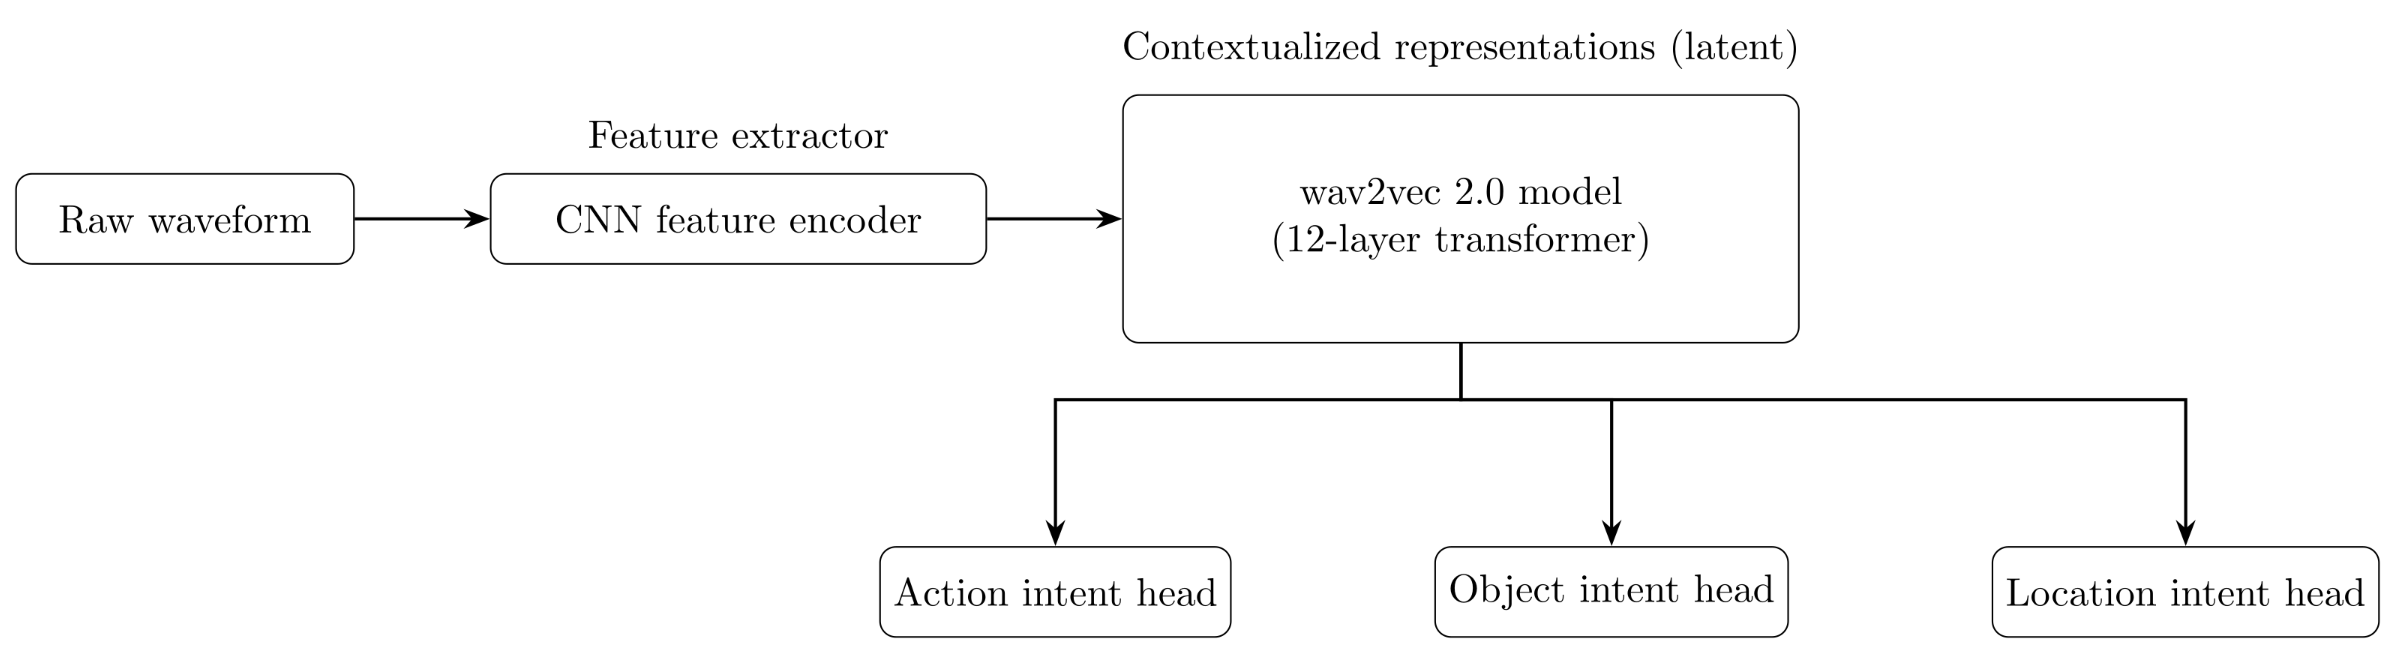

> Shen, G., Mohebbi, H., Bisazza, A., Alishahi, A., & Chrupała, G. (2025). On the reliability of feature attribution methods for speech classification. arXiv preprint arXiv:2505.16406.

In [ ]:
#@title Load the pre-trained model from Hugging Face
# This model is a multi classifier head, multi class classification model fine-tuned on the FSC-IC dataset
# It has three heads for action, object, and location classification
# The model is based on Wav2Vec2 and uses a multi-label classification approach with a customized model class.

model = AutoModelForAudioClassification.from_pretrained(
    "techsword/wav2vec2-base-fsc-ic-multiheadmultilabel", trust_remote_code=True
)

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
model.to(device)
model.eval()

config.json: 0.00B [00:00, ?B/s]

configuration_wav2vec2multihead.py:   0%|          | 0.00/501 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/techsword/wav2vec2-base-fsc-ic-multiheadmultilabel:
- configuration_wav2vec2multihead.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_wav2vec2multihead.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/techsword/wav2vec2-base-fsc-ic-multiheadmultilabel:
- modeling_wav2vec2multihead.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Wav2Vec2ForMultiHeadMultiLabelClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inpl

You can see at the bottom of the outputs from the cell above that this custom model has three classifiers at the end. Each classifier being responsible for one Intent Classification target in the Fluent Speech Commands dataset.

# Let's make sure the model works!

We will run five examples in our selected dataset and see how the model performs

In [ ]:
# Let's check the model's performance on some examples from the dataset
for example in dataset.select(range(5)):  # type: ignore
    # Select the first 5 examples from the dataset
    audio = example["audio"]["array"]  # type: ignore
    audio = torch.tensor(audio, dtype=torch.float).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(audio)

    # We can save the three logit values for each of the classifiers
    logits1 = output.logits1
    logits2 = output.logits2
    logits3 = output.logits3

    class_1 = logits1.argmax(dim=-1).item()
    class_2 = logits2.argmax(dim=-1).item() + model.config.num_labels_1
    class_3 = (
        logits3.argmax(dim=-1).item()
        + model.config.num_labels_1
        + model.config.num_labels_2
    )

    ipd.display(ipd.Audio(audio.squeeze().cpu().numpy(), rate=16000))
    print(f"Transcription: {example['transcription']}")  # type: ignore
    print(
        f"Predicted labels: {model.config.id2label[class_1]}, {model.config.id2label[class_2]}, {model.config.id2label[class_3]}"
    )

    real_class_1 = example["action"]  # type: ignore
    real_class_2 = example["object"] + model.config.num_labels_1  # type: ignore
    real_class_3 = (
        example["location"] + model.config.num_labels_1 + model.config.num_labels_2  # type: ignore
    )
    print(
        f"Real labels: {model.config.id2label[real_class_1]}, {model.config.id2label[real_class_2]}, {model.config.id2label[real_class_3]}"
    )
    print("-" * 50)



Transcription: I couldn't hear anything, turn up the volume
Predicted labels: increase, volume, none_location
Real labels: increase, volume, none_location
--------------------------------------------------


Transcription: Fetch the newspaper
Predicted labels: bring, newspaper, none_location
Real labels: bring, newspaper, none_location
--------------------------------------------------


Transcription: Turn the bedroom heat down
Predicted labels: decrease, heat, bedroom
Real labels: decrease, heat, bedroom
--------------------------------------------------


Transcription: Switch the lights on
Predicted labels: activate, lights, none_location
Real labels: activate, lights, none_location
--------------------------------------------------


Transcription: Turn down the volume
Predicted labels: decrease, volume, none_location
Real labels: decrease, volume, none_location
--------------------------------------------------


# The Feature attribution part!
We are following a similar procedure laid out in the Captum tutorial for BERT models  
The following code cell includes helper function to run the feature attribution pipeline and then plotting the results.


In [ ]:
#@title Helper functions
input_type_lookup = {
    "input": "Waveform",
    "spec": "Spectrogram",
    "embedding": "CNN Embedding",
}
attr_method_lookup = {
    "ig": "Integrated Gradients",
    "saliency": "Saliency",
    "lime": "LIME",
    "occlusion": "Occlusion",
    "featureablation": "Feature Ablation"
}


def plot_feat_attribution(
    subtask="action",
    input_type="input",
    attr_method_name="ig",
    random_seed=42,
    word_level=False,
):
    """Plot the feature attribution for a given subtask, input type, and attribution method."""

    wrapper_model = WrapperModelMultiHead(model, input_type=input_type)
    attr_method = choose_attr_method(attr_method_name, wrapper_model)


    attr_method_fullname = attr_method_lookup[attr_method_name]
    input_type_fullname = input_type_lookup[input_type]

    renamed_dataset = copy.deepcopy(dataset).rename_column(subtask, "label")
    # Shuffle the renamed_dataset to ensure a random selection of examples
    renamed_dataset = renamed_dataset.shuffle(random_seed)

    classifier_to_idx = {"action": 0, "object": 1, "location": 2}
    additional_forward_args = (classifier_to_idx[subtask],)

    example = renamed_dataset[0]  # Get the first example from the dataset

    # Run feature attribution on the sample
    results = attribute(
        attr_method,
        example,
        batch_size=8,
        additional_forward_args=additional_forward_args,
        word_level=word_level,
    ).squeeze()

    if input_type != "input":
        # We sum over the feature dimension if the input type is not waveform
        results = results.mean(-1)

    real_label = dataset.features[subtask].int2str(example["label"])  # type: ignore

    if word_level:
        # If word_level is True, we need to summarize the attribution scores over the
        # words using the timestamp information from the textgrid
        word_level_results = align_score_with_forced_alignment(
            example, attributions=results, input_type=input_type
        )

        # Plot the attribution scores for word-level attribution
        # Word level results is a list of tuples (word, score)
        plt.figure(figsize=(12, 6), dpi=150)
        plt.bar(
            [word[0] for word in word_level_results],
            [word[1] for word in word_level_results],
            color="blue",
        )

        # Put the word labels on the x-axis
        plt.xticks(rotation=45, ha="right")
        plt.title(
            f"Attribution for {subtask} classification in FSC dataset, real label: {real_label}. \n Input type: {input_type_fullname}, Attribution method: {attr_method_fullname}"
        )
        plt.xlabel("Words")
        plt.ylabel("Attribution score")
        plt.tight_layout()
        plt.show()

    else:  # Plotting the attribution scores for frame-level attribution
        plt.figure(figsize=(12, 6), dpi=150)
        plt.plot(results)
        # alignments = textgrids.TextGrid(example["textgrid_path"])
        alignments = example["textgrid"]  # type: ignore
        # Use the alignments to plot some vertical red lines for each word in the alignment
        for word in alignments["words"]:  # type: ignore
            if len(word["text"]) == 0:
                # Skip silence
                continue
            start = word["xmin"] * 16000  # Convert timestap from seconds to samples
            end = word["xmax"] * 16000  # Convert timestap from seconds to samples
            if input_type != "input":
                # If the input type is not "input", we need to convert the start and end times to the number of frames
                # And the wav2vec2 has a 20ms stride, so we need to divide the start and end times by 320
                # 16000 samples per second / 50 frames per second = 320 samples per frame
                # So we divide the start and end times by 320 to get the number of frames
                start = start // 320
                end = end // 320

            # print(f"Word: {word['text']}, Start: {start}, End: {end}")
            plt.plot(
                [start, start],
                [results.min(), results.max()],
                color="red",
                linewidth=0.5,
            )
            # Add the text of the word centered between the start and end times
            plt.text(
                (start + end) / 2,
                results.max(),
                word["text"],
                color="brown",
                fontsize=8,
                horizontalalignment="center",
                verticalalignment="bottom",
            )

        plt.title(
            f"Attribution for {subtask} classification in FSC dataset, real label: {real_label}. \n Input type: {input_type_fullname}, Attribution method: {attr_method_fullname}"
        )
        plt.xlabel("Time (samples or frames)")
        plt.ylabel("Attribution score")

        plt.show()


After setting up everything, we can now test the effects of different variables in the speech model feature attribution setup.

subtask is one of three Intents the model is capable of classifying

Input_Signal_for_FA is the type of input we want to attribute back to. We can choose from waveform, spectrogram or CNN embedding.

Attribution_Method contains a variety of methods we can choose. Including perturbation based methods like "Feature Ablation" and also gradient based methods like "Integrated Gradients"

Random_seed controls the random sampling of the sample we're running feature attribution on.

For perturbation based methods, the word_level parameter controls if entire word chunks are being perturbated. And word_level also controls the summarization step. Essentially we use the word-level alignment timestamp to pool feature attribution scores together.

**When running the code cell below, feel free to copy-and-paste or duplicate the cell so you can compare across different subtasks, input signals and/or attribution methods!**

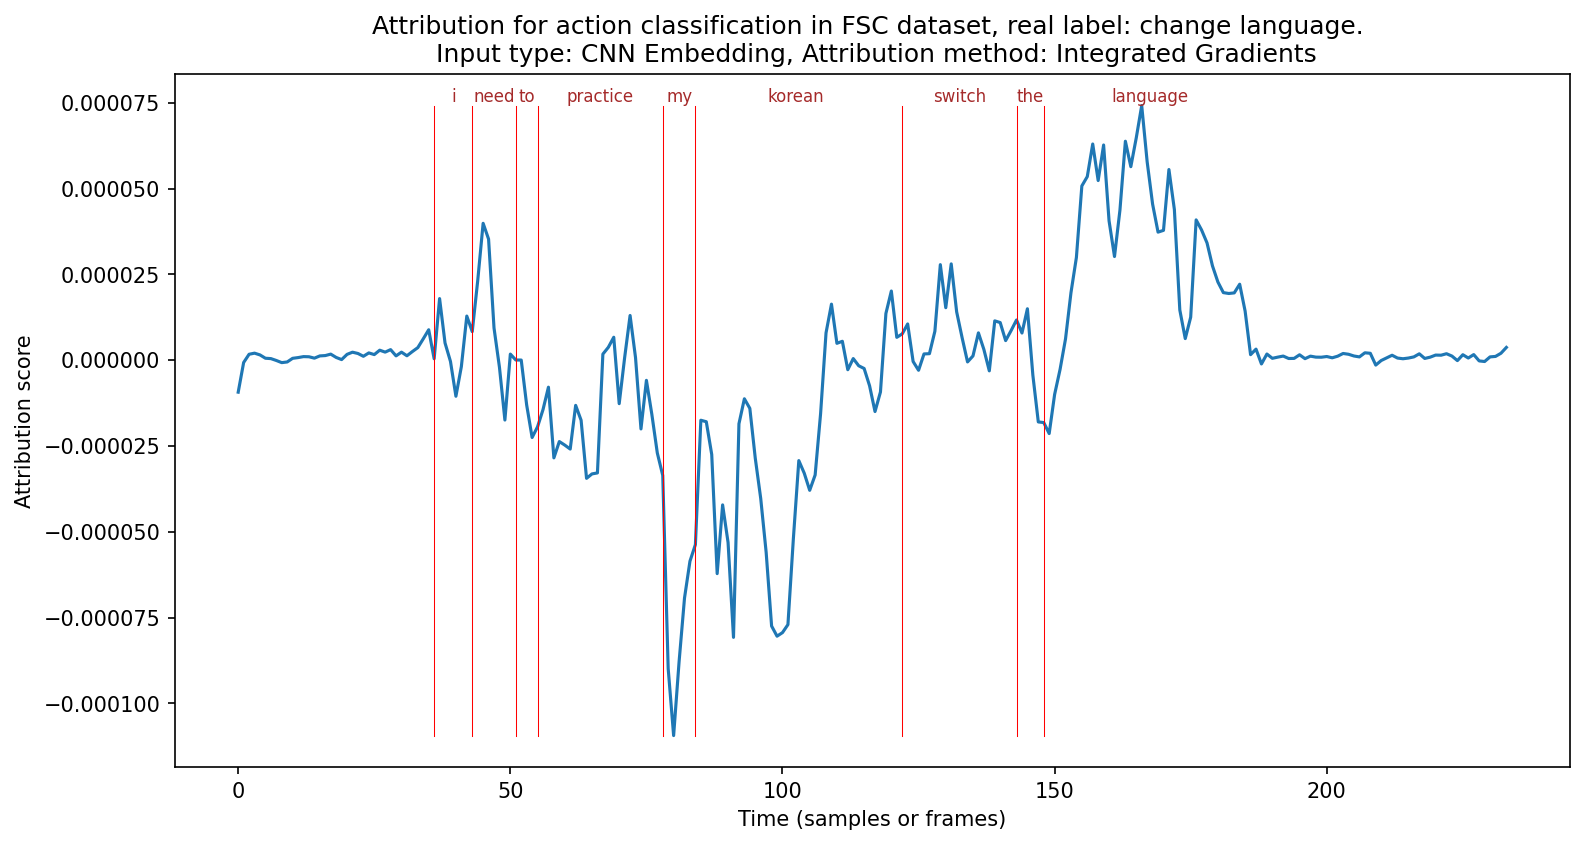

In [ ]:
# Choose the subtask within the intent classification task
subtask = "action"  #@param ["action", "object", "location"]

# Choose the input types
Input_Signal_for_FA = "CNN Embedding" #@param ["Waveform", "Spectrogram", "CNN Embedding"]
input_type = {v: k for k, v in input_type_lookup.items()}[Input_Signal_for_FA]

# Choose what attribution method you want to use
Attribution_Method = "Integrated Gradients" #@param ["Integrated Gradients", "Saliency", "LIME", "Feature Ablation"]
attr_method_name = {v: k for k, v in attr_method_lookup.items()}[Attribution_Method]

# Seed for random selection of examples
random_seed = 85 #@param {type: "slider", min: 0, max: 999}
# Whether to use word-level attribution or not
word_level = False  #@param {type: "boolean"}

# Use feature attribution to find out which parts of the audio are important for the prediction
plot_feat_attribution(
    subtask=subtask,
    input_type=input_type,
    attr_method_name=attr_method_name,
    word_level=word_level,
    random_seed=random_seed,
)


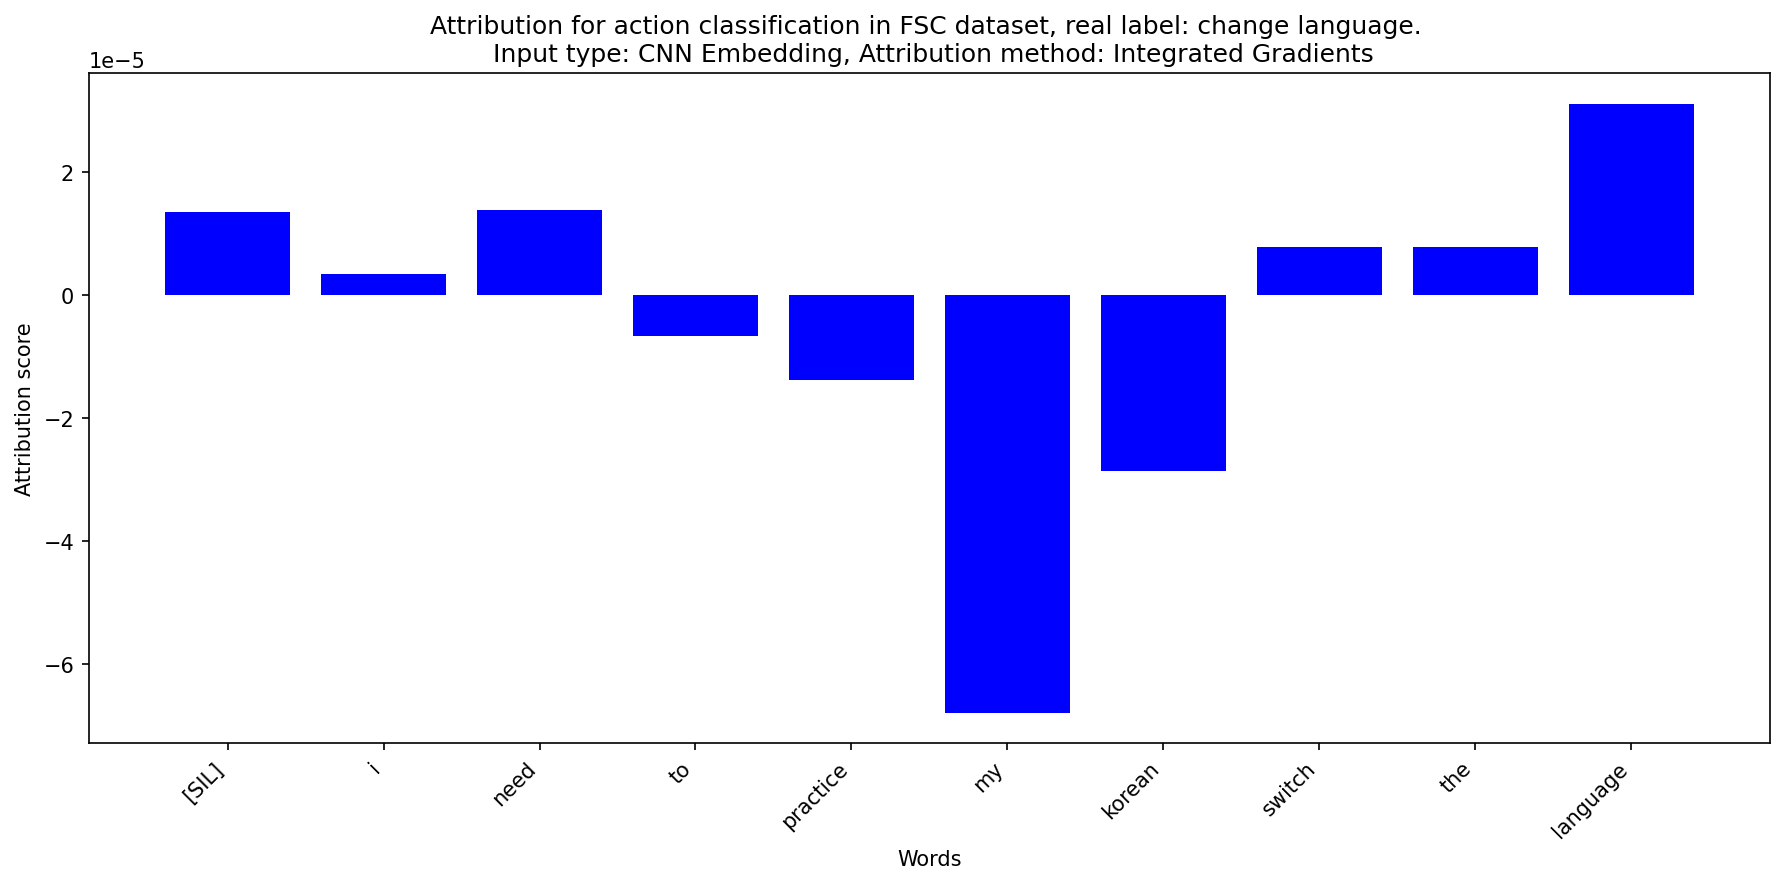

In [ ]:
# Choose the subtask within the intent classification task
subtask = "action"  #@param ["action", "object", "location"]

# Choose the input types
Input_Signal_for_FA = "CNN Embedding" #@param ["Waveform", "Spectrogram", "CNN Embedding"]
input_type = {v: k for k, v in input_type_lookup.items()}[Input_Signal_for_FA]

# Choose what attribution method you want to use
Attribution_Method = "Integrated Gradients" #@param ["Integrated Gradients", "Saliency", "LIME", "Feature Ablation"]
attr_method_name = {v: k for k, v in attr_method_lookup.items()}[Attribution_Method]

# Seed for random selection of examples
random_seed = 85 #@param {type: "slider", min: 0, max: 999}
# Whether to use word-level attribution or not
word_level = True  #@param {type: "boolean"}

# Use feature attribution to find out which parts of the audio are important for the prediction
plot_feat_attribution(
    subtask=subtask,
    input_type=input_type,
    attr_method_name=attr_method_name,
    word_level=word_level,
    random_seed=random_seed,
)


# Last words:

Feel free to dig into the files tab on the left into the interspeech_2025_interp_tutorial folder to see what the actual attribute function look like in the `helper.py` file.